# Demo: PBMC68k dataset

The demo shows the usage of scClassifier2.

The PBMC68k dataset can be downloaded from the 10x Genomics website.

## Train scClassifier2

The PBMC68k dataset is divided into two the train subset and the test subset. Run scClassifier2 on the training data to get the classification model.

The command to run the training process is as follows.

``` shell
python scClassifier2.py --sup-data-file /DATA2/Project/MICE_evaluation/data/PBMC68k/pbmc68k_dataset_roc_train.mtx \
                        --sup-label-file /DATA2/Project/MICE_evaluation/data/PBMC68k/pbmc68k_dataset_label_text_roc_train.txt \
                        -lr 0.0001 \
                        -n 30 \
                        -bs 100 \
                        --aux-loss \
                        --cross-validation-fold 10 \
                        --cuda \
                        --runtime \
                        --jit \
                        --best-valid-model pbmc68k_model.pth                 
```

## Test scClassifier2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)


import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from scClassifier2 import scClassifier2
from utils.scdata_cached import SingleCellCached

import torch
from torch.utils.data import DataLoader

## Load model and test datset

In [2]:
ModelPath = 'pbmc68k_model.pth'
DataPath='/DATA2/Project/MICE_evaluation/data/PBMC68k/pbmc68k_dataset_roc_test.mtx'
LabelPath='/DATA2/Project/MICE_evaluation/data/PBMC68k/pbmc68k_dataset_label_text_roc_test.txt'

In [3]:
# load model
model = torch.load(ModelPath)

In [4]:
# load data
batch_size = 100

# Apply log-transformation on data or not.
# If count data is provided, log-transformation
# should be used. 
log_trans = False

# Put data on cuda or not.
use_cuda = True

# Randomly permute data or not.
shuffle = False

label_encoder = model.label2class
data_cached = SingleCellCached(DataPath, LabelPath, label_encoder, 'roc', log_trans = log_trans, use_cuda = use_cuda)
data_loader = DataLoader(data_cached, batch_size = batch_size, shuffle = shuffle)


## Run prediction on the test data

In [5]:
# predict
predictions, scores, actuals = [], [], []

# use the appropriate data loader
for (xs, ys) in data_loader:
    # use classification function to compute all predictions for each batch
    yhats, yscores = model.classifier_with_probability(xs)
    scores.append(yscores)

    _, yhats = torch.topk(yhats, 1)
    yhats = model.convert_to_label(yhats)
    predictions.append(yhats)

    _, ys = torch.topk(ys, 1)
    ys = model.convert_to_label(ys)
    actuals.append(ys)

predictions = np.concatenate(predictions, 0)
scores = torch.cat(scores, dim=0).cpu().detach().numpy()
actuals = np.concatenate(actuals, 0)

Save the classification scores for plotting ROC curves.

In [6]:
scores = pd.DataFrame(scores)
scores.columns = model.convert_to_label(torch.from_numpy(np.arange(model.output_size)))

scores['True'] = actuals
scores['Pred'] = predictions

In [7]:
scores

,CD14+ Monocyte,CD19+ B,CD34+,CD4+ T Helper2,CD4+/CD25 T Reg,CD4+/CD45RA+/CD25- Naive T,CD4+/CD45RO+ Memory,CD56+ NK,CD8+ Cytotoxic T,CD8+/CD45RA+ Naive Cytotoxic,Dendritic,True,Pred
0,1.440956e-15,4.124883e-15,4.928924e-12,1.119431e-06,1.853160e-06,5.635591e-09,1.340757e-02,2.357817e-08,9.623362e-01,2.425318e-02,7.188880e-12,CD8+ Cytotoxic T,CD8+ Cytotoxic T
1,2.457121e-15,4.109367e-11,1.014722e-13,7.367043e-12,1.595733e-11,1.324306e-07,3.287981e-14,5.131664e-21,3.526704e-09,9.999999e-01,5.580277e-11,CD8+/CD45RA+ Naive Cytotoxic,CD8+/CD45RA+ Naive Cytotoxic
2,2.642756e-20,1.018128e-19,6.836291e-15,2.934076e-09,2.485034e-15,2.286355e-13,6.420543e-08,2.353857e-06,9.999850e-01,1.259038e-05,1.328911e-14,CD8+ Cytotoxic T,CD8+ Cytotoxic T
3,4.154542e-06,6.687131e-06,1.733673e-05,2.409457e-04,9.882890e-02,1.839479e-02,2.869002e-03,2.553523e-07,1.417879e-03,8.673096e-01,1.091046e-02,CD8+/CD45RA+ Naive Cytotoxic,CD8+/CD45RA+ Naive Cytotoxic
4,3.302217e-08,9.498194e-07,1.403170e-07,8.787499e-06,1.433785e-02,6.514722e-02,6.719754e-05,3.398274e-11,9.929788e-05,9.203360e-01,2.467924e-06,CD8+/CD45RA+ Naive Cytotoxic,CD8+/CD45RA+ Naive Cytotoxic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,6.573569e-22,5.094497e-18,3.324802e-19,1.243376e-16,1.412492e-16,3.074152e-12,2.109909e-19,1.984417e-23,1.014089e-11,1.000000e+00,3.917623e-17,CD8+/CD45RA+ Naive Cytotoxic,CD8+/CD45RA+ Naive Cytotoxic
6854,2.802597e-45,0.000000e+00,4.556903e-38,5.025511e-33,0.000000e+00,1.780027e-40,1.761761e-39,1.000000e+00,1.748931e-17,1.724245e-36,6.236199e-41,CD56+ NK,CD56+ NK
6855,2.195927e-15,2.117143e-14,2.805948e-13,2.149205e-06,1.835680e-03,1.554952e-12,6.912190e-02,9.453889e-11,9.290341e-01,6.281846e-06,1.897661e-10,CD8+ Cytotoxic T,CD8+ Cytotoxic T
6856,1.399327e-09,1.677099e-06,1.104134e-08,2.220044e-06,1.848516e-01,5.751708e-06,7.479940e-04,4.175128e-12,1.175321e-04,8.142650e-01,8.262421e-06,CD8+/CD45RA+ Naive Cytotoxic,CD8+/CD45RA+ Naive Cytotoxic


Save scores for ROC analysis.

```python
scores.to_csv('pbmc68k_scc2_pred_scores.txt', index=False)
```

Performance assessment

In [8]:
accuracy_score(actuals, predictions)

0.868183143773695

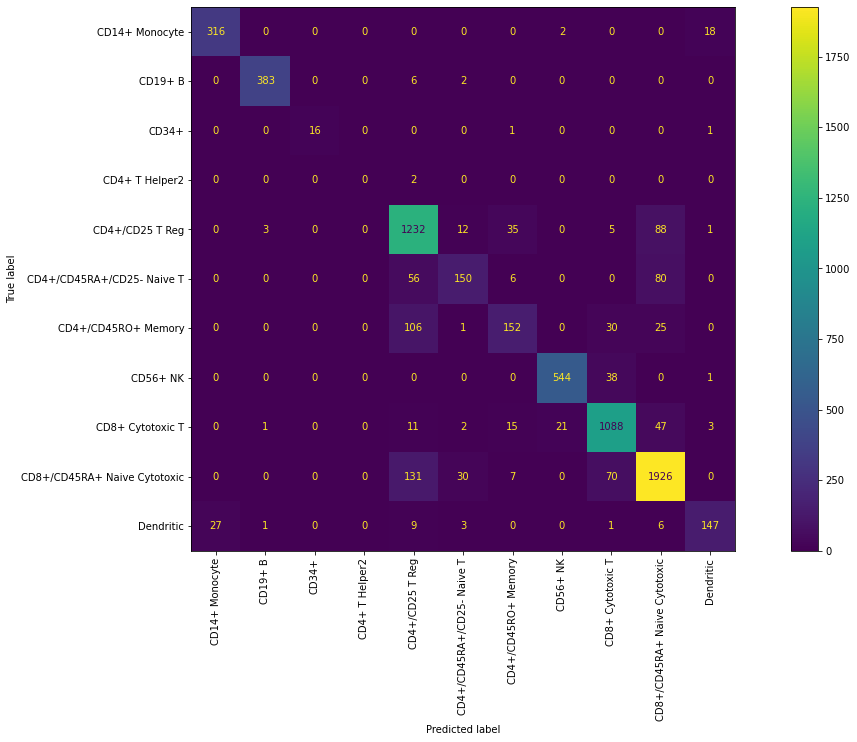

In [9]:
ConfusionMatrixDisplay.from_predictions(actuals, predictions, xticks_rotation='vertical')